In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config

set_config(display="diagram")
pd.set_option("display.max_column", None)
warnings.filterwarnings(action="ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)
sns.set_style(style="darkgrid")
%matplotlib inline

In [ ]:
df: DataFrame = pd.read_csv(filepath_or_buffer=r"D:\Python\data analysis projects\L1 L2\Melbourne_housing_FULL.csv")
df: DataFrame = pd.concat(objs=[df.iloc[:,0:4], df.iloc[:,5:], df.loc[:,"Price"]], axis=1)
df.head()

# DATA CLEANING
## Check for duplicate values
## Check for the missing data

In [ ]:
# Check for duplicate values
# keep only the first row
df.drop_duplicates(keep="first", inplace=True)
df[df.duplicated()]

In [ ]:
df.info()

In [ ]:
# check for missing data (nan values)
df.isna().sum()[df.isna().sum() > 0]

In [ ]:
df1 = df.copy()
df1 = df1[['Suburb','Rooms', 'Type', 'Method', 'SellerG', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize',
        'BuildingArea', 'YearBuilt', 'CouncilArea', 'Regionname', 'Propertycount', 'Price']]
df1

In [ ]:
for idx, value in df1.isna().sum()[df1.isna().sum() > 0].items():
    print(f"column name: {idx}")
    # missing data percentage
    print(f"{value} : {((value / 34856) * 100):.3f}%")

In [ ]:
df1[df1.isna().sum()[df1.isna().sum() > 0].index.to_list()]

In [77]:
df1["CouncilArea"].value_counts(dropna=False, ascending=False)
df1["CouncilArea"].ffill(inplace=True)

df1["Propertycount"].value_counts(dropna=False, ascending=False)
df1["Propertycount"].fillna(value=df1["Propertycount"].mean(), inplace=True)

df1["Regionname"].value_counts(dropna=False, ascending=False)
df1["Regionname"].ffill(inplace=True)



In [79]:
df1["Distance"].value_counts(dropna=False, ascending=False)
df1["Distance"].fillna(value=df1["Distance"].mean(), inplace=True)

In [ ]:
df1

In [ ]:
missing_columns = df1.isna().sum()[df1.isna().sum() > 0].index.to_list()

tree_preprocessor = ColumnTransformer(
    transformers=[
        ("DecisionTreeRegressorImputer", IterativeImputer(estimator=DecisionTreeRegressor(random_state=42), missing_values=np.nan), missing_columns)
    ],
    remainder='passthrough'
)

tree_imputed = tree_preprocessor.fit_transform(df1)
tree_imputed = pd.DataFrame(data=tree_imputed, columns=missing_columns + [col for col in df1.columns if col not in missing_columns])
tree_imputed = tree_imputed[df1.columns]
tree_imputed

In [ ]:
numeric_columns = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Propertycount', 'Price']
tree_imputed[numeric_columns] = tree_imputed[numeric_columns].apply(pd.to_numeric, errors="coerce")
sns.heatmap(tree_imputed[numeric_columns].isna())

In [ ]:
from tqdm.notebook import tqdm

# Assuming 'tree_imputed' is your input DataFrame
# Step 1: Select categorical columns
category_column = tree_imputed.select_dtypes(include="object", exclude="number").columns.to_list()

# Step 2: Create a preprocessor for categorical columns using OneHotEncoder
categorical_preprocessor_tree = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False), category_column)
    ], remainder="passthrough"
)

# Step 3: Apply the transformation and convert the result to a DataFrame
tree_df = categorical_preprocessor_tree.fit_transform(X=tree_imputed)

# Step 4: Get the names of encoded columns and passthrough columns
encoded_columns = categorical_preprocessor_tree.named_transformers_["OneHotEncoder"].get_feature_names_out(input_features=category_column)
passthrough_columns = [col for col in tree_imputed.columns if col not in category_column]
df_columns = list(encoded_columns) + passthrough_columns

# Convert the transformed data into a DataFrame
tree_df = pd.DataFrame(data=tree_df, columns=df_columns)

# Step 5: Define features (X) and target (Y)
X = tree_df.iloc[:, :-1]  # All columns except the last one as features
Y = tree_df.iloc[:, -1]   # Last column as target

# Step 6: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, train_size=0.2, random_state=11)

# Step 7: Define the alpha values and KFold cross-validator
alpha_values = np.linspace(start=0, stop=100, num=100)  # Alphas to try
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Initialize variables to store the best model
best_alpha = None
best_score = -np.inf
best_coefficients = None

# Use tqdm to monitor the cross-validation progress over different alpha values
for alpha in tqdm(alpha_values, desc="Cross-validation progress"):
    fold_scores = []
    
    # Perform K-Fold cross-validation
    for train_index, test_index in kf.split(X_train):
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Train Ridge model on the current fold
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_fold_train, y_fold_train)
        
        # Evaluate the model on the test fold and store the score
        score = ridge.score(X_fold_test, y_fold_test)
        fold_scores.append(score)
    
    # Calculate the mean score across folds for the current alpha
    mean_score = np.mean(fold_scores)
    
    # Update best model if this score is the best so far
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha
        best_coefficients = ridge.coef_

# Step 8: Print the results
print("Best alpha:", best_alpha)
print("Best score:", best_score)
print("Best coefficients:", best_coefficients)


In [ ]:
# Standardize the data (important for regularized regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Initialize variables to store the best model
best_alpha = None
best_score = -np.inf
best_coefficients = None
alpha_values = np.linspace(start=0.001, stop=1, num=50)  # Narrower alpha range


for alpha in tqdm(alpha_values, desc="Lasso Regression"):
    lasso_list = []
    
    # KFold cross-validation
    for train_index, test_index in kf.split(X_train_scaled):
        # Split the fold
        X_fold_train, X_fold_test = X_train_scaled[train_index], X_train_scaled[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Train the model
        lasso = Lasso(alpha=alpha).fit(X_fold_train, y_fold_train)
        
        # Evaluate the model
        score = lasso.score(X_fold_test, y_fold_test)
        lasso_list.append(score)
    
    mean_score_lasso = np.mean(lasso_list)
    
    # Update the best model
    if mean_score_lasso > best_score:
        best_score = mean_score_lasso
        best_alpha = alpha
        best_coefficients = lasso.coef_

print("Best alpha:", best_alpha)
print("Best score:", best_score)
print("Best coefficients:", best_coefficients)

In [ ]:
# Linear regression (Regressor)
""" ------------------------------------- high Variance ------------------------------------------------------"""
regressor = LinearRegression().fit(X_train, y_train)
print(regressor.score(X=X_train, y=y_train)) # 0.6063212966507059
print(regressor.score(X=X_test, y=y_test)) # -380.25187395541377

In [ ]:
k = np.int64(np.ceil(np.sqrt(df.shape[0])))
nn = k if k % 2 != 0 else k - 1

knn_preprocessor = ColumnTransformer(
    transformers=[
        ("knn_imputer", KNNImputer(missing_values=np.nan, weights="distance",n_neighbors=nn), missing_columns)
    ],
    remainder="passthrough"
)

knn_imputed = knn_preprocessor.fit_transform(df1)
knn_imputed = pd.DataFrame(data=knn_imputed, columns= missing_columns + [col for col in df1.columns if col not in missing_columns])
knn_imputed: DataFrame = knn_imputed[df1.columns]
knn_imputed

In [ ]:
for i in [knn_imputed, tree_imputed]:
    # check for missing data in both models 
    print(i.isna().sum()[i.isna().sum() > 0])
    print()

In [ ]:
knn_imputed[df1.columns]

In [ ]:
tips: DataFrame = sns.load_dataset(name="tips")
tips

In [ ]:
# Group by 'sex' and 'smoker' to get the count
gender_smoker_count: DataFrame = tips.groupby(by=['sex', 'smoker']).size().reset_index(name='count')

# Create the subplots
plt.figure(figsize=(12, 6))

# Bar plot using seaborn for the first subplot
plt.subplot(1, 2, 1)
sns.barplot(x='sex', y='count', hue='smoker', data=gender_smoker_count, palette="coolwarm")
plt.xlabel(xlabel="Gender")
plt.ylabel(ylabel="Count")
plt.title(label="Smoker vs Non-Smoker by Gender")

# Second plot using plt.bar
plt.subplot(1, 2, 2)
gender_smoker_pivot = tips.pivot_table(index='sex', columns='smoker', aggfunc='size')
gender_smoker_pivot.plot(kind='bar', stacked=True, ax=plt.gca(), color=['green', 'crimson'])
plt.xlabel(xlabel="Gender")
plt.ylabel(ylabel="Count")
plt.title(label="Stacked Bar Plot of Smoker vs Non-Smoker by Gender")

plt.tight_layout()
plt.show()

In [ ]:
gender_smoker_count

In [ ]:
tips: DataFrame = pd.get_dummies(data=tips).astype(dtype=np.int64)
tips

In [ ]:
from tqdm.notebook import tqdm

X: DataFrame = tips.drop(labels="tip", axis=1)
Y: Series = tips.loc[:, "tip"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, train_size=0.2, random_state=11)
standard_scaler = StandardScaler()

X_scaled_train = standard_scaler.fit_transform(X_train)
X_scaled_test = standard_scaler.fit_transform(X_test)

alphas = np.linspace(start=0, stop=100, num=100)
alpha_values_log = np.logspace(start=4, stop=1, num=100)
best_alpha = None
best_score = -np.inf  # Initialize to negative infinity for maximization

for alpha in tqdm(alphas, desc="ElasticNet Tuning"):
    elastic_net = []
    for train_index, test_index in KFold(n_splits=10, shuffle=True, random_state=42).split(X_scaled_train):
        X_fold_train, X_fold_test = X_scaled_train[train_index], X_scaled_train[test_index]
        Y_fold_train, Y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Create cross-validation for ElasticNet (Hybrid L1 and L2)
        elastic_cv = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=1000).fit(X=X_fold_train, y=Y_fold_train)
        
        # Scores to the list
        elastic_net.append(elastic_cv.score(X=X_fold_test, y=Y_fold_test))
    
    elastic_mean = np.mean(elastic_net)
    
    if elastic_mean > best_score:
        best_score = elastic_mean
        best_alpha = alpha  # This should be the current alpha in the loop

print("best_alpha:", best_alpha)
print("best_score:", best_score)


In [ ]:
elastic_net = ElasticNet(alpha=1.0101010101010102)
elastic_net.fit(X=X_train, y=y_train)
y_pred = elastic_net.predict(X_test)
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("mean_absolute_error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))
print("mean_squared_error:", mean_squared_error(y_true=y_test, y_pred=y_pred))

R2: 0.1971853479926451
mean_absolute_error: 0.8919179782183747
mean_squared_error: 1.4594065291267604


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "alpha" : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
    "l1_ratio" : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}

grid_cv = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid, scoring="neg_mean_squared_error", cv=KFold(n_splits=10, shuffle=True, random_state=11))
grid_cv.fit(X_train, y_train)
y_pred = grid_cv.predict(X_test)


print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("mean_absolute_error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))
print("mean_squared_error:", mean_squared_error(y_true=y_test, y_pred=y_pred))


# Gradient decent

In [ ]:
from numpy._typing._array_like import NDArray
from typing import Literal


def y_function(x: int | float) -> int | float:return x ** 2
def y_derivative(x: int | float) -> int | float: return 2 * x

x: NDArray[np.float64] = np.arange(start=-100, stop=100, step=0.1)
y: int | float = y_function(x=x)

current_position: tuple[Literal[80], int | float] = (80, y_function(x=80))
learning_rate= 0.01

for _ in range(1000):
    new_x: float = current_position[0] - learning_rate * y_derivative(x=current_position[0])
    new_y: int | float = y_function(x=new_x)
    
    current_position = (new_x, new_y)
    
    plt.plot(x, y)
    plt.scatter(x=current_position[0], y=current_position[1], color="red")
    plt.pause(interval=0.001)
    plt.clf()
    plt.tight_layout()



# Gradient decent (3D)

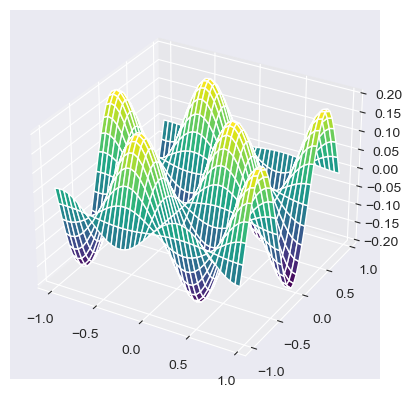

In [21]:

def z_function(x, y):
    return np.sin(5 * x) * np.cos(5 * y) / 5

def gradient_decent(x, y):
    """Return the derivative of z_function (Product Rule)"""
    return np.cos(5 * x) * np.cos(5 * y), np.sin(5 * x) * -np.sin(5 * y)

x = np.arange(start=-1, stop=1, step=0.05)
y = np.arange(start=-1, stop=1, step=0.05)

X, Y = np.meshgrid(x, y)
Z = z_function(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})  # Corrected the `projection` placement
ax.plot_surface(X, Y, Z, cmap='viridis')  # Use `cmap` instead of `color`
plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Any
from pandas import DataFrame, Series
import numpy as np
import pyarrow as pa


df: DataFrame = pd.read_csv(
    filepath_or_buffer=r"D:\Python\IBM Data Analyst Professional Certificate\Data Analysis with Python\clean_cars_df.csv"
)
df. drop(labels=df.columns[0], axis=1, inplace=True)
numeric_data_type = df.select_dtypes(include="number", exclude="string")
numeric_data_type

symboling  normalized-losses  wheel-base    length     width    height  \
0            3                122        88.6  0.811148  0.890278  0.816054   
1            3                122        88.6  0.811148  0.890278  0.816054   
2            1                122        94.5  0.822681  0.909722  0.876254   
3            2                164        99.8  0.848630  0.919444  0.908027   
4            2                164        99.4  0.848630  0.922222  0.908027   
..         ...                ...         ...       ...       ...       ...   
196         -1                 95       109.1  0.907256  0.956944  0.928094   
197         -1                 95       109.1  0.907256  0.955556  0.928094   
198         -1                 95       109.1  0.907256  0.956944  0.928094   
199         -1                 95       109.1  0.907256  0.956944  0.928094   
200         -1                 95       109.1  0.907256  0.956944  0.928094   

     curb-weight  engine-size  bore  stroke  compression-ratio  horsepower  \
0           2548          130  3.47    2.68                9.0         111   
1           2548          130  3.47    2.68                9.0         111   
2           2823          152  2.68    3.47                9.0         154   
3           2337          109  3.19    3.40               10.0         102   
4           2824          136  3.19    3.40                8.0         115   
..           ...          ...   ...     ...                ...         ...   
196         2952          141  3.78    3.15                9.5         114   
197         3049          141  3.78    3.15                8.7         160   
198         3012          173  3.58    2.87                8.8         134   
199         3217          145  3.01    3.40               23.0         106   
200         3062          141  3.78    3.15                9.5         114   

     peak-rpm  city-mpg  highway-L/100km    price  city-L/100km  
0      5000.0        21         8.703704  13495.0     11.190476  
1      5000.0        21         8.703704  16500.0     11.190476  
2      5000.0        19         9.038462  16500.0     12.368421  
3      5500.0        24         7.833333  13950.0      9.791667  
4      5500.0        18        10.681818  17450.0     13.055556  
..        ...       ...              ...      ...           ...  
196    5400.0        23         8.392857  16845.0     10.217391  
197    5300.0        19         9.400000  19045.0     12.368421  
198    5500.0        18        10.217391  21485.0     13.055556  
199    4800.0        26         8.703704  22470.0      9.038462  
200    5400.0        19         9.400000  22625.0     12.368421  

[201 rows x 17 columns]

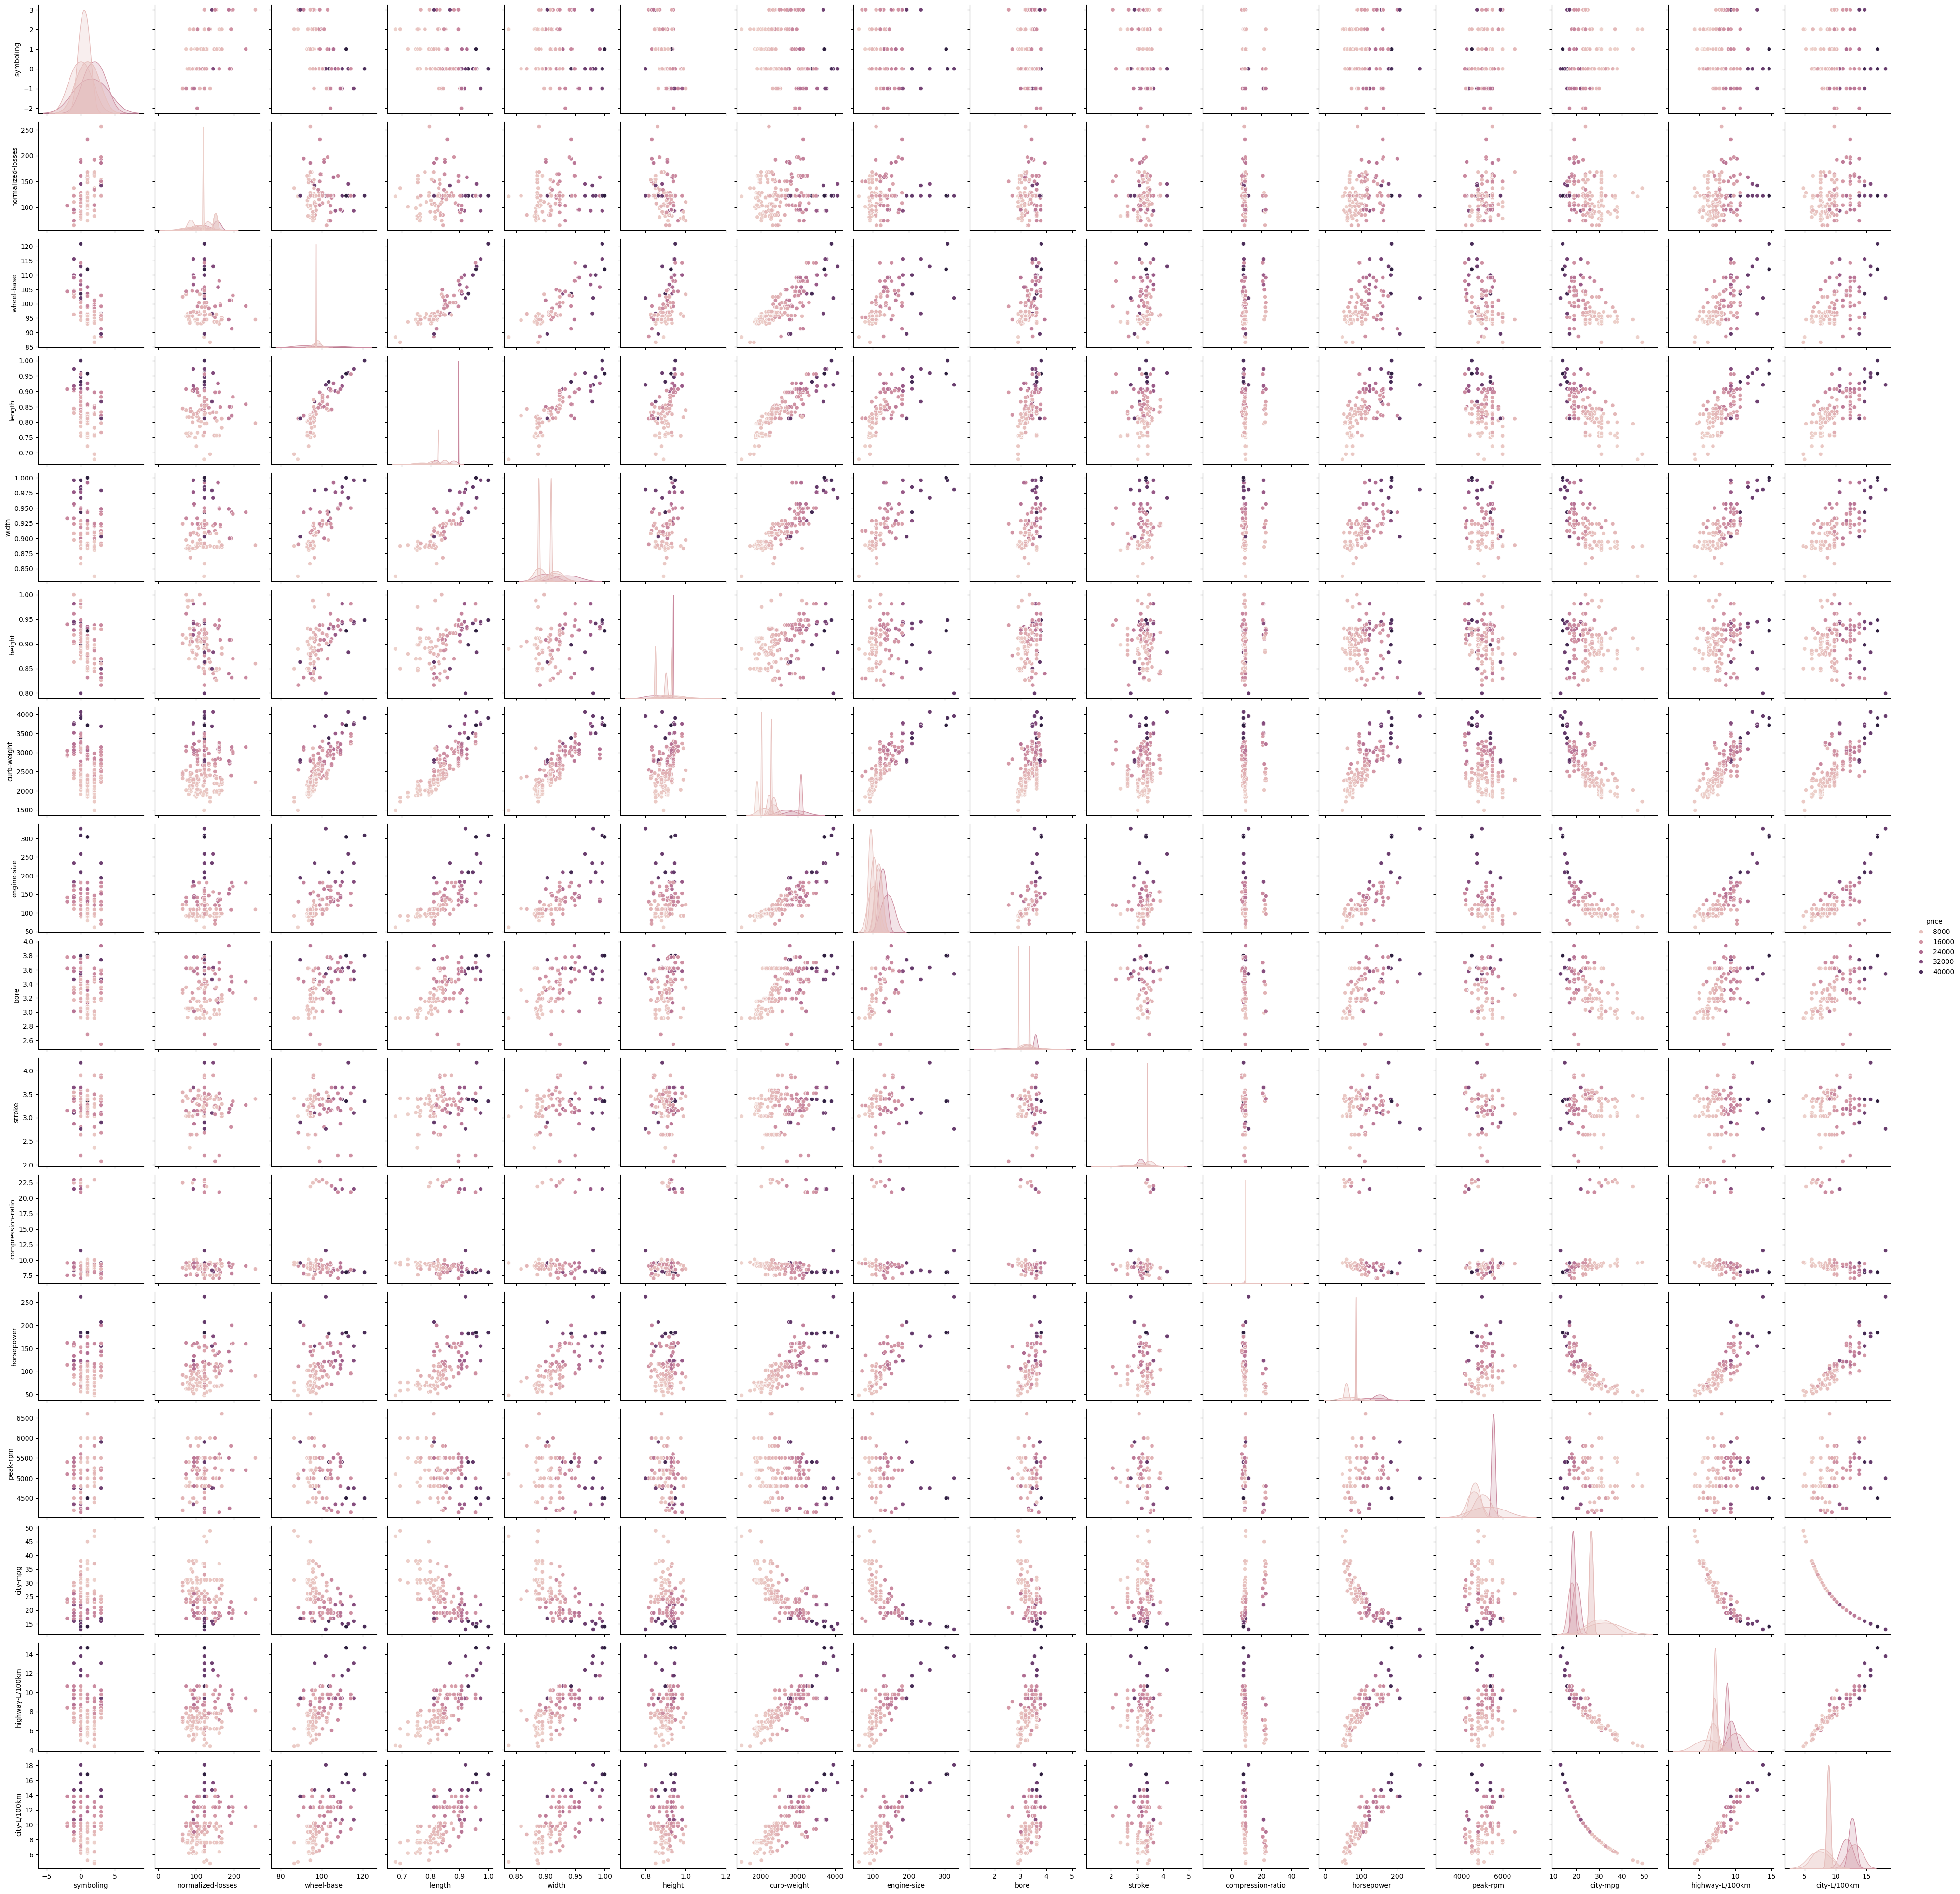

In [9]:
import seaborn as sns

sns.pairplot(data=numeric_data_type, hue="price")

## Loss function (mean square error)

In [10]:
def loss_function(b0, b1, points):
    total_error = 0
    for i in range(len(points)):
        x = df["highway-L/100km"].iloc[i]
        y = df["price"].iloc[i]

        # y_hat
        y_pred = b0 + b1 * x
        
        total_error += (y - y_pred) ** 2
    total_error /= float(x=len(points))
    return total_error


epochs: 0
epochs: 1000
epochs: 2000
epochs: 3000
epochs: 4000
epochs: 5000
epochs: 6000
epochs: 7000
epochs: 8000
epochs: 9000
-14616.997019215354 3458.5850848886425


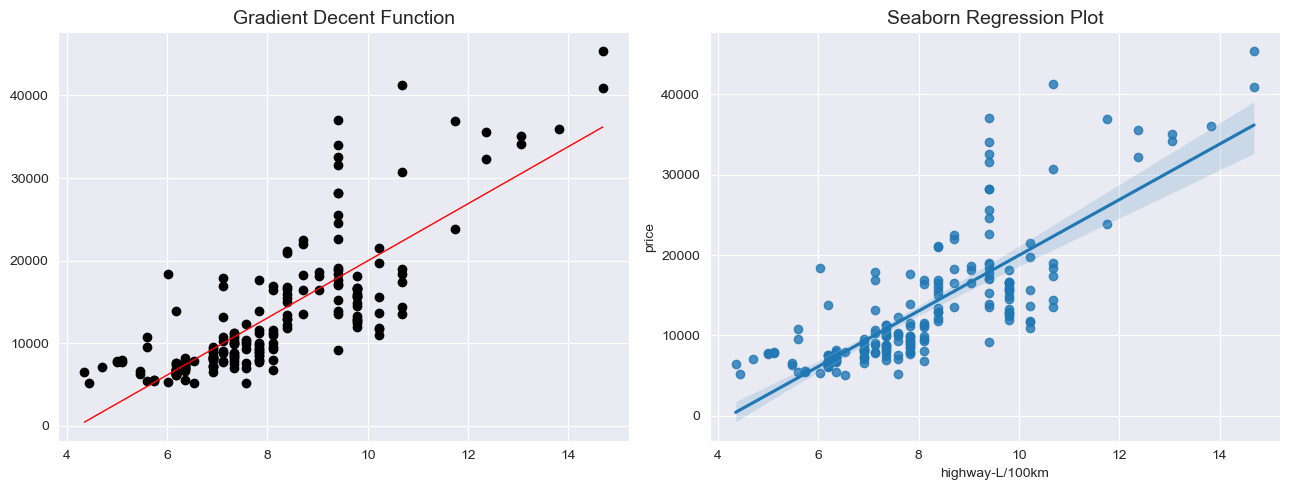

In [36]:
def gradient_decent(b0, b1, points, learning_rate):
    b0_gradient = 0
    b1_gradient = 0
    
    #length of the data 
    N = len(points)
    
    for i in range(N):
        x = points["highway-L/100km"].iloc[i]
        y = points["price"].iloc[i]
        
        y_pred = b0 + b1 * x
        
        # derivatives equations for b0 and b1
        b0_gradient += -(2/N) * (y - y_pred)
        b1_gradient += -(2/N) * x * (y - y_pred)
    
    # update b0 and b1
    b0 = b0 - learning_rate * b0_gradient
    b1 = b1 - learning_rate * b1_gradient
    
    return b0, b1

b0 = 0
b1 = 0
learning_rate = 0.01
epochs = 10000 # number of iterations
for i in range(epochs):
    if i % 2000 == 0:
        print(f"epochs: {i}")
    b0, b1 = gradient_decent(b0=b0,b1=b1,points=df, learning_rate=learning_rate)
print(b0, b1)

x_values = np.linspace(min(df["highway-L/100km"]), max(df["highway-L/100km"]), 100)
y_values = b0 + b1 * x_values

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.scatter(df["highway-L/100km"], df["price"], color="black")
plt.plot(x_values, y_values, lw=1, color="red")
plt.title(label="Gradient decent function".title(), fontsize=14)
plt.subplot(1,2,2)
sns.regplot(x=df["highway-L/100km"], y=df["price"])
plt.title(label="seaborn regression plot".title(), fontsize=14)
sns.set_style(style="darkgrid")
plt.tight_layout()
plt.show()


<Axes: xlabel='highway-L/100km', ylabel='price'>

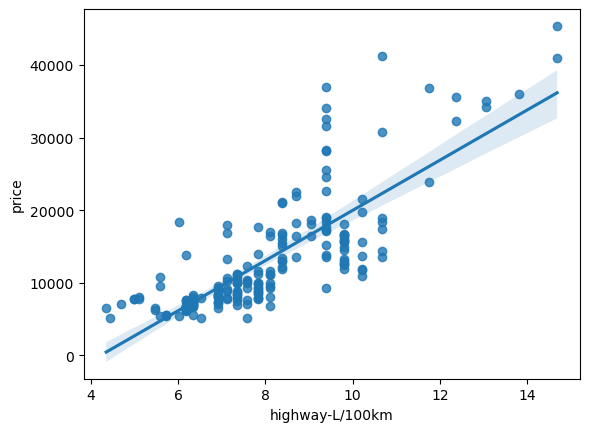